In [1]:
#|default_exp sgd

In [124]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [125]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(1)

Loading the data

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

### SGD

Defining the callbacks of the model:
   - the metrics callback
   - the Device callback
   - the progress bar callback

And the callbacks for the learning rate finder step:
   - the Device callback
   - the LRFinder callback

We need to set the activation to GeneralRelu with `leak`iness 0.1 and a vertical shift `sub` of 0.4.

We also need to initialize the weights with Kaiming init for leaky ReLUs of leaky slope `leaky=0.1`.

In [134]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [136]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [137]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

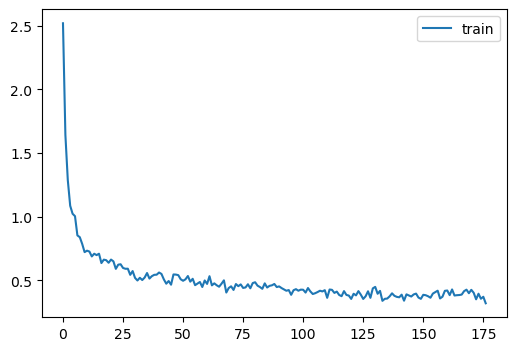

In [138]:
learn.fit(3)

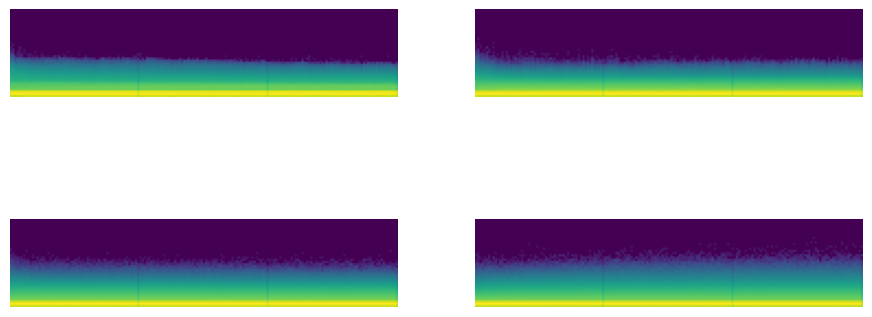

In [139]:
astats.color_dim()

### Momentum

In [140]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

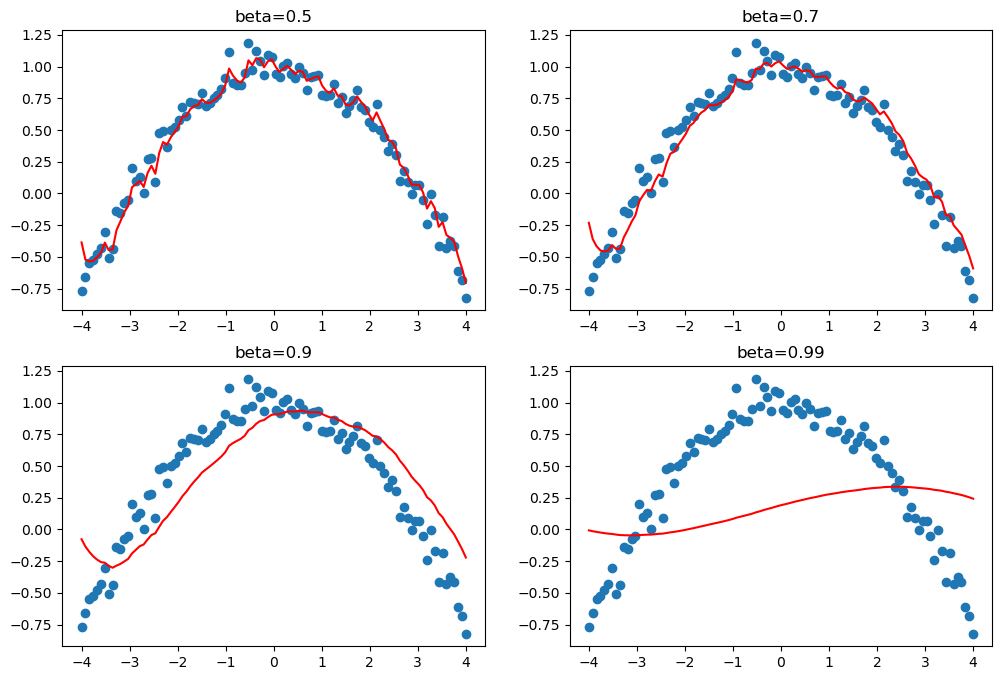

In [141]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0,[]
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [142]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

In [143]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

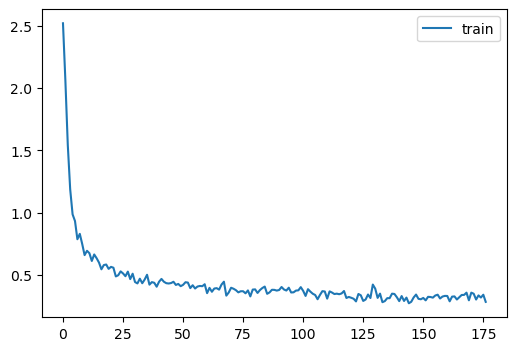

In [144]:
learn.fit(3)

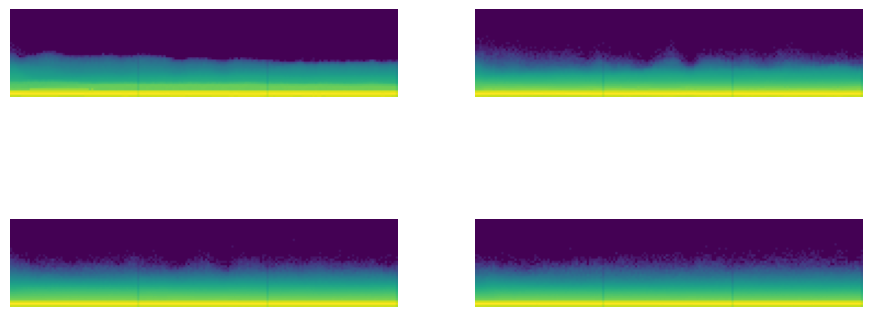

In [145]:
astats.color_dim()

### RMSProp

In [146]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom,self.eps = sqr_mom,eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

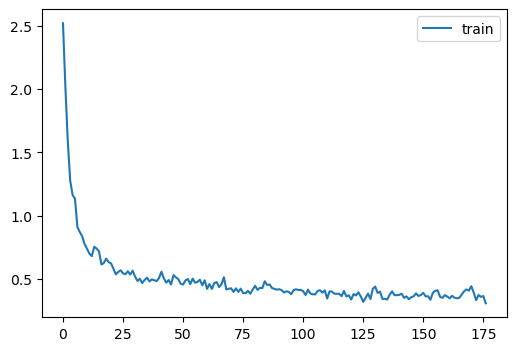

In [147]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

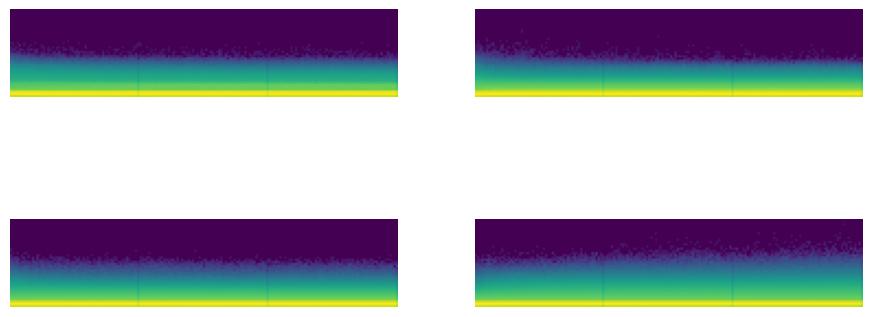

In [148]:
astats.color_dim()

### Adam

In [149]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

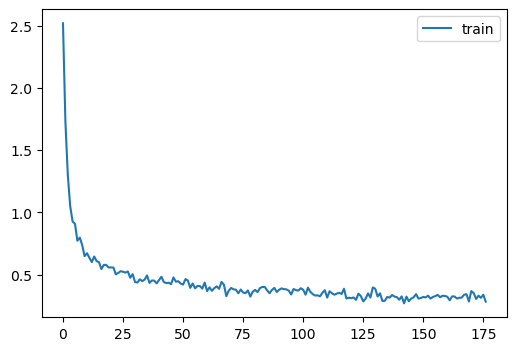

In [150]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

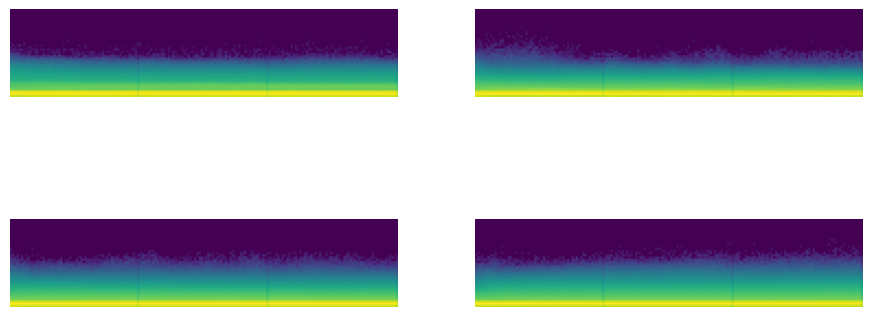

In [151]:
astats.color_dim()